In [2]:
import psycopg2
from psycopg2 import Error

try:
    connection = psycopg2.connect(user = "bismarckvm",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "test_bismarck")

    cursor = connection.cursor()
    
    create_table_query = '''CREATE TABLE mobile
          (ID INT PRIMARY KEY     NOT NULL,
          MODEL           TEXT    NOT NULL,
          PRICE         REAL); '''
    
    cursor.execute(create_table_query)
    connection.commit()
    print("Table created successfully in PostgreSQL ")

except (Exception, psycopg2.DatabaseError) as error :
    print ("Error while creating PostgreSQL table", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

Table created successfully in PostgreSQL 
PostgreSQL connection is closed


In [5]:
import sklearn.datasets

In [6]:
iris = sklearn.datasets.load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 1

# Linear Model

In [ ]:
CREATE TABLE linear_model(
    mid serial PRIMARY KEY,
    parms double precision[]
);

# Logistic Regression

In [ ]:
DROP FUNCTION IF EXISTS sigmoid(double precision) CASCADE;
CREATE FUNCTION sigmoid(z double precision)
    RETURNS double precision
AS $$
    import numpy as np
    
    return 1 / (1 + np.exp(-z))
$$ LANGUAGE plpythonu;


In [ ]:
DROP FUNCTION IF EXISTS dense_logit_agg(double precision[], integer, double precision[]) CASCADE;
CREATE FUNCTION dense_logit_agg(x double precision[], y integer, linear_model double precision[])
    RETURNS double precision[]
AS $$
    import numpy as np

    mu = linear_model[0]
    lr = linear_model[1]
    w = linear_model[2:]
    wx = np.dot(x, w) 

    sig = 1.0 / (1.0 + np.exp(wx * y))
    c = lr * y * sig
    u = mu * lr

    for i in range(len(w)):
        w[i] += x[i] * c
        if w[i] > u:
            w[i] -= u
        elif w[i] < -u:
            w[i] += u
        else:
            w[i] = 0.0
            
    return [mu, lr] + w
$$ LANGUAGE plpythonu;

DROP FUNCTION IF EXISTS dense_logit_loss(double precision[], integer, double precision[]) CASCADE;
CREATE FUNCTION dense_logit_loss(x double precision[], y integer, linear_model double precision[])
    RETURNS double precision
AS $$
    import numpy as np
    
    w = linear_model[2:]
    wx = np.dot(x, w)

    return np.log(1.0 + np.exp(- y * wx))

$$ LANGUAGE plpythonu;


In [ ]:
DROP FUNCTION IF EXISTS logit_agg(double precision[], integer, double precision[]) CASCADE;
CREATE FUNCTION logit_agg(x double precision[], y integer, linear_model double precision[])
    RETURNS double precision[]
AS $$
    import numpy as np

    lr = linear_model[0]
    theta = linear_model[1:]
    
    z = np.dot(x, theta) 
    h = 1 / (1 + np.exp(-z))
    gradient = np.dot(x, (h - y))
    for i in range(len(theta)):
        theta[i] -= lr * gradient[i]
    return [lr] + theta
$$ LANGUAGE plpythonu;

In [ ]:
DROP FUNCTION IF EXISTS logit_loss(double precision[], integer, double precision[]) CASCADE;
CREATE FUNCTION logit_loss(x double precision[], y integer, linear_model double precision[])
    RETURNS double precision
AS $$
    import numpy as np
    
    x_array = np.array(x)
    lr = linear_model[0]
    theta = linear_model[1:]
    
    z = np.dot(x_array, theta)
    h = 1 / (1 + np.exp(-z))
    
    return -y * np.log(h) - (1 - y) * np.log(1 - h)
$$ LANGUAGE plpythonu;

In [ ]:
CREATE FUNCTION logit_agg_iteration(data_table text, model_id integer)
RETURNS double precision 
AS $$
DECLARE
    weight_vector double precision[];
    loss double precision;
    BEGIN
    -- grad
    EXECUTE 'SELECT logit_agg(vec, labeli, 
                            (SELECT parms 
                             FROM linear_model 
                             WHERE mid = ' || model_id || ')) '
            || 'FROM ' || quote_ident(data_table)
        INTO weight_vector;
    -- update
    UPDATE linear_model SET parms = weight_vector WHERE mid = model_id;
    -- loss
    EXECUTE 'SELECT sum(logit_loss(vec, labeli, 
                           (SELECT parms
                            FROM linear_model 
                            WHERE mid = ' || model_id || '))) '
            || 'FROM ' || quote_ident(data_table)
        INTO loss;
    RETURN loss;
END;
$$ LANGUAGE plpgsql VOLATILE;

In [ ]:
CREATE FUNCTION logit_train_agg(data_table text, model_id integer, iteration integer)
RETURNS VOID 
AS $$
DECLARE
    loss double precision;
    BEGIN
    FOR i IN 1..iteration LOOP
        SELECT logit_agg_iteration(data_table, model_id) INTO loss;
        RAISE NOTICE '#iter: %, loss value: %', i, loss;
    END LOOP;
END;
$$ LANGUAGE plpgsql VOLATILE;

In [ ]:
DROP FUNCTION IF EXISTS alloc_float8_array(double precision, integer) CASCADE;
CREATE FUNCTION alloc_float8_array(mu double precision, n integer)
RETURNS double precision[]
AS $$
    w = [0.0 for _ in range(n)]
    return [mu] + w
$$ LANGUAGE plpythonu;

In [ ]:
DROP FUNCTION IF EXISTS dense_logit(text, integer, integer, integer, double precision, boolean) CASCADE;
CREATE FUNCTION dense_logit(
    data_table text,
    model_id integer,
    ndims integer,
    iteration integer /* default 20 */,
    mu double precision /* default 1e-2 */,
    is_shuffle boolean /* default 'true' */)
RETURNS VOID AS $$
DECLARE
    ntuples integer;
    tmp_table text;
    initw double precision[] := '{0}';
BEGIN
    -- query for ntuples and initialize the model table 
    EXECUTE 'SELECT count(*) FROM ' || data_table
        INTO ntuples;	
    SELECT alloc_float8_array(mu, ndims) INTO initw;
    DELETE FROM linear_model WHERE mid = model_id;
    INSERT INTO linear_model VALUES (model_id, initw); 
    -- execute iterations
    IF is_shuffle THEN
        tmp_table := '__bismarck_shuffled_' || data_table || '_' || model_id;
        EXECUTE 'DROP TABLE IF EXISTS ' || tmp_table || ' CASCADE';
        EXECUTE 'CREATE TABLE ' || tmp_table || ' AS 
            SELECT * FROM ' || data_table || ' ORDER BY random()';
        RAISE NOTICE 'A shuffled table % is created for training', tmp_table;
    ELSE
        tmp_table := data_table;
    END IF;

    PERFORM logit_train_agg(tmp_table, model_id, iteration);
END;
$$ LANGUAGE plpgsql VOLATILE;

DROP FUNCTION IF EXISTS dense_logit(text, integer, integer) CASCADE;
CREATE FUNCTION dense_logit(
    data_table text,
    model_id integer,
    ndims integer)
RETURNS VOID AS $$
    SELECT dense_logit($1, $2, $3, 20, 1e-2, 't');
$$ LANGUAGE sql VOLATILE;

In [26]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            for j in range(len(X)):
                x = X[j]
                z = np.dot(x, self.theta)

                h = self.__sigmoid(z)

                gradient = np.dot(x.T, (h - y[j]))

                self.theta -= self.lr * gradient

                if(self.verbose == True and i % 10000 == 0):
                    z = np.dot(x, self.theta)
                    h = self.__sigmoid(z)
                    print(f'loss: {self.__loss(h, y)} \t')
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold=0.5):
        return self.predict_prob(X) >= threshold

In [27]:
model = LogisticRegression(lr=0.1, num_iter=300)
%time  
model.fit(X, y)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [28]:
preds = model.predict(X)
# accuracy
(preds == y).mean()

0.9933333333333333

In [29]:
model.theta

array([ -7.79730935,   8.8748636 , -12.48484305])

# SVM

In [ ]:
DROP FUNCTION IF EXISTS svm_agg(double precision[], integer, double precision[]) CASCADE;
CREATE FUNCTION svm_agg(x double precision[], y integer, linear_model double precision[])
    RETURNS double precision[]
AS $$
    import numpy as np

    learn_rate = linear_model[0]
    step_size = linear_model[1]
    theta = linear_model[2:]
    
    v = np.dot(x, theta)
    if (y * v < 1):
        gradient = np.dot(theta, - step_size)
        gradient = [y * x[i] - gradient[i] for i in range(len(gradient))]
    else:
        gradient =  np.dot(theta, - step_size)

    for i in range(len(theta)):
        theta[i] += learn_rate * gradient[i]
        
    return [learn_rate, step_size] + theta
$$ LANGUAGE plpythonu;

In [ ]:
DROP FUNCTION IF EXISTS svm_loss(double precision[], integer, double precision[]) CASCADE;
CREATE FUNCTION svm_loss(x double precision[], y integer, linear_model double precision[])
    RETURNS double precision
AS $$
    import numpy as np
    
    learn_rate = linear_model[0]
    step_size = linear_model[1]
    theta = linear_model[2:]
    v = np.dot(x, theta)
    
    return max(0, 1 - y * v)
$$ LANGUAGE plpythonu;

In [ ]:
DROP FUNCTION IF EXISTS svm_agg_iteration(text, integer) CASCADE;
CREATE FUNCTION svm_agg_iteration(data_table text, model_id integer)
RETURNS double precision 
AS $$
DECLARE
    weight_vector double precision[];
    loss double precision;
    BEGIN
    -- grad
    EXECUTE 'SELECT svm_agg(vec, labeli, 
                            (SELECT parms 
                             FROM linear_model 
                             WHERE mid = ' || model_id || ')) '
            || 'FROM ' || quote_ident(data_table)
        INTO weight_vector;
    -- update
    UPDATE linear_model SET parms = weight_vector WHERE mid = model_id;
    -- loss
    EXECUTE 'SELECT sum(svm_loss(vec, labeli, 
                           (SELECT parms
                            FROM linear_model 
                            WHERE mid = ' || model_id || '))) '
            || 'FROM ' || quote_ident(data_table)
        INTO loss;
    RETURN loss;
END;
$$ LANGUAGE plpgsql VOLATILE;

In [ ]:
DROP FUNCTION IF EXISTS svm_train_agg(text, integer, integer) CASCADE;
CREATE FUNCTION svm_train_agg(data_table text, model_id integer, iteration integer)
RETURNS VOID 
AS $$
DECLARE
    loss double precision;
    BEGIN
    FOR i IN 1..iteration LOOP
        SELECT svm_agg_iteration(data_table, model_id) INTO loss;
        RAISE NOTICE '#iter: %, loss value: %', i, loss;
    END LOOP;
END;
$$ LANGUAGE plpgsql VOLATILE;

In [ ]:
DROP FUNCTION IF EXISTS alloc_float8_array(double precision, double precision, integer) CASCADE;
CREATE FUNCTION alloc_float8_array(mu double precision, s double precision, n integer)
RETURNS double precision[]
AS $$
    w = [0.0 for _ in range(n)]
    return [mu, s] + w
$$ LANGUAGE plpythonu;

In [ ]:
DROP FUNCTION IF EXISTS dense_svm(text, integer, integer, integer, double precision, boolean) CASCADE;
CREATE FUNCTION dense_svm(
    data_table text,
    model_id integer,
    ndims integer,
    iteration integer /* default 20 */,
    mu double precision /* default 1e-2 */,
    stepsize double precision /* default 5e-5 */,
    is_shuffle boolean /* default 'true' */)
RETURNS VOID AS $$
DECLARE
    ntuples integer;
    tmp_table text;
    initw double precision[] := '{0}';
BEGIN
    -- query for ntuples and initialize the model table 
    EXECUTE 'SELECT count(*) FROM ' || data_table
        INTO ntuples;	
    SELECT alloc_float8_array(mu, stepsize, ndims) INTO initw;
    DELETE FROM linear_model WHERE mid = model_id;
    INSERT INTO linear_model VALUES (model_id, initw); 
    -- execute iterations
    IF is_shuffle THEN
        tmp_table := '__bismarck_shuffled_' || data_table || '_' || model_id;
        EXECUTE 'DROP TABLE IF EXISTS ' || tmp_table || ' CASCADE';
        EXECUTE 'CREATE TABLE ' || tmp_table || ' AS 
            SELECT * FROM ' || data_table || ' ORDER BY random()';
        RAISE NOTICE 'A shuffled table % is created for training', tmp_table;
    ELSE
        tmp_table := data_table;
    END IF;

    PERFORM svm_train_agg(tmp_table, model_id, iteration);
END;
$$ LANGUAGE plpgsql VOLATILE;

DROP FUNCTION IF EXISTS dense_svm(text, integer, integer) CASCADE;
CREATE FUNCTION dense_svm(
    data_table text,
    model_id integer,
    ndims integer)
RETURNS VOID AS $$
    SELECT dense_svm($1, $2, $3, 20, 1e-2, 5e-5, 't');
$$ LANGUAGE sql VOLATILE;

In [1]:
# importing some basic libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np

In [2]:
class SVM(object):
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    
    def fit(self, data):
        #train with data
        self.data = data
        # { |\w\|:{w,b}}
        opt_dict = {}
        
        transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]
        
        all_data = np.array([])
        for yi in self.data:
            all_data = np.append(all_data,self.data[yi])
                    
        self.max_feature_value = max(all_data)         
        self.min_feature_value = min(all_data)
        all_data = None
        
        #with smaller steps our margins and db will be more precise
        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      #point of expense
                      self.max_feature_value * 0.001,]
        
        #extremly expensise
        b_range_multiple = 5
        #we dont need to take as small step as w
        b_multiple = 5
        
        latest_optimum = self.max_feature_value*10
        
        """
        objective is to satisfy yi(x.w)+b>=1 for all training dataset such that ||w|| is minimum
        for this we will start with random w, and try to satisfy it with making b bigger and bigger
        """
        #making step smaller and smaller to get precise value
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            
            #we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*self.max_feature_value*b_range_multiple,
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        
                        #weakest link in SVM fundamentally
                        #SMO attempts to fix this a bit
                        # ti(xi.w+b) >=1
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b)>=1:
                                    found_option=False
                        if found_option:
                            """
                            all points in dataset satisfy y(w.x)+b>=1 for this cuurent w_t, b
                            then put w,b in dict with ||w|| as key
                            """
                            opt_dict[np.linalg.norm(w_t)]=[w_t,b]
                
                #after w[0] or w[1]<0 then values of w starts repeating itself because of transformation
                #Think about it, it is easy
                #print(w,len(opt_dict)) Try printing to understand
                if w[0]<0:
                    optimized=True
                    print("optimized a step")
                else:
                    w = w-step
                    
            # sorting ||w|| to put the smallest ||w|| at poition 0 
            norms = sorted([n for n in opt_dict])
            #optimal values of w,b
            opt_choice = opt_dict[norms[0]]

            self.w=opt_choice[0]
            self.b=opt_choice[1]
            
            #start with new latest_optimum (initial values for w)
            latest_optimum = opt_choice[0][0]+step*2
    
    def predict(self,features):
        #sign(x.w+b)
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        if classification!=0 and self.visualization:
            self.ax.scatter(features[0],features[1],s=200,marker='*',c=self.colors[classification])
        return (classification,np.dot(np.array(features),self.w)+self.b)
    
    def visualize(self):
        [[self.ax.scatter(x[0],x[1],s=100,c=self.colors[i]) for x in data_dict[i]] for i in data_dict]
        
        # hyperplane = x.w+b (actually its a line)
        # v = x0.w0+x1.w1+b -> x1 = (v-w[0].x[0]-b)/w1
        #psv = 1     psv line ->  x.w+b = 1a small value of b we will increase it later
        #nsv = -1    nsv line ->  x.w+b = -1
        # dec = 0    db line  ->  x.w+b = 0
        def hyperplane(x,w,b,v):
            #returns a x2 value on line when given x1
            return (-w[0]*x-b+v)/w[1]
       
        hyp_x_min= self.min_feature_value*0.9
        hyp_x_max = self.max_feature_value*1.1
        
        # (w.x+b)=1
        # positive support vector hyperplane
        pav1 = hyperplane(hyp_x_min,self.w,self.b,1)
        pav2 = hyperplane(hyp_x_max,self.w,self.b,1)
        self.ax.plot([hyp_x_min,hyp_x_max],[pav1,pav2],'k')
        
        # (w.x+b)=-1
        # negative support vector hyperplane
        nav1 = hyperplane(hyp_x_min,self.w,self.b,-1)
        nav2 = hyperplane(hyp_x_max,self.w,self.b,-1)
        self.ax.plot([hyp_x_min,hyp_x_max],[nav1,nav2],'k')
        
        # (w.x+b)=0
        # db support vector hyperplane
        db1 = hyperplane(hyp_x_min,self.w,self.b,0)
        db2 = hyperplane(hyp_x_max,self.w,self.b,0)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2],'y--')

In [3]:
#defining a basic data
data_dict = {-1:np.array([[1,7],[2,8],[3,8]]),1:np.array([[5,1],[6,-1],[7,3]])}

optimized a step
optimized a step
optimized a step


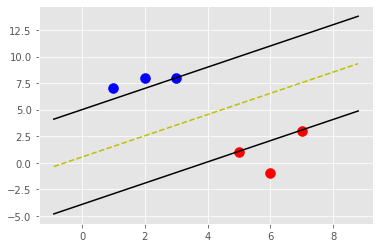

In [4]:
svm = SVM() # Linear Kernel
svm.fit(data=data_dict)
svm.visualize()

In [5]:
svm.predict([3,8])

(-1.0, -1.000000000000098)

In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
#Input data
x = np.array([
    [-2,4,-1],
    [4,1,-1],
    [1, 6, -1],
    [2, 4, -1],
    [6, 2, -1],

])


#output label
y = np.array([-1, -1, 1, 1, 1])

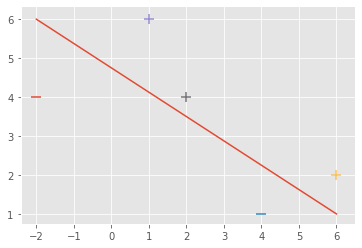

In [8]:
for val, inp in enumerate(x):
    if y[val] == -1:
        plt.scatter(inp[0], inp[1], s=100, marker='_', linewidths=5)
    else:
        plt.scatter(inp[0], inp[1], s=100, marker='+', linewidths=5)

plt.plot([-2,6],[6,1])

In [9]:
def svm_function(x,y):
    #initilizing weight
    w = np.zeros(len(x[0]))
    #initialize learning rate
    l_rate = 1
    #epoch
    epoch = 100000
    #output list
    out = []
    #training svm
    for e in range(epoch):
        for i, val in enumerate(x):
            val1 = np.dot(x[i], w)
            if (y[i]*val1 < 1):
                w = w + l_rate * ((y[i]*x[i]) - (2*(1/epoch)*w))
            else:
                w = w + l_rate * (-2*(1/epoch)*w)
    
    for i, val in enumerate(x):
        out.append(np.dot(x[i], w))
    
    return w, out

In [10]:
w, out = svm_function(x,y)

In [11]:
print('Calculated weights')
print(w)

Calculated weights
[ 1.50157001  3.00057251 10.50863266]


In [12]:
print('predicted output')
print(out)

predicted output
[-1.509482661019593, -1.5017801059577938, 8.996372385026156, 4.496797386268188, 4.501932422976054]


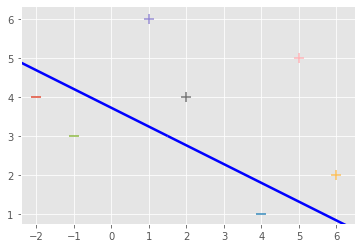

In [13]:
u = np.array([
    [-1,3,-1],
    [5,5,-1],
    
])
   
    
for val, inp in enumerate(x):
    if y[val] == -1:
        plt.scatter(inp[0], inp[1], s=100, marker='_', linewidths=5)
    else:
        plt.scatter(inp[0], inp[1], s=100, marker='+', linewidths=5)

plt.scatter(-1,3, s=100, marker='_', linewidths=5)   
plt.scatter(5,5, s=100, marker='+', linewidths=5)   


x1=[w[0],w[1],-w[1],w[0]]
x2=[w[0],w[1],w[1],-w[0]]

x1x2 =np.array([x1,x2])
X,Y,U,V = zip(*x1x2)
ax = plt.gca()
ax.quiver(X,Y,U,V,scale=1, color='blue')